# Preprocessing and Spectrogram Dataset Preparation

### Environment Setup and Dependencies

This cell imports essential libraries required for audio processing, data handling, and model development, including `librosa`, `TensorFlow`, `NumPy`, and `matplotlib`. A random seed is initialized to ensure reproducibility of results. The directory structure is also configured using `pathlib`, and the project root and dataset path are defined. Additionally, a utility function `segment_audio` is imported from the custom `audio_utils` module for audio segmentation tasks.


In [ ]:
from pathlib import Path
import os, sys, random
import numpy as np
import librosa
import tensorflow as tf   
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd
from typing import List, Tuple, Union
from tqdm.notebook import tqdm


SEED = 2025
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

NOTEBOOK_DIR = Path.cwd()
PROJECT_ROOT = NOTEBOOK_DIR.parent
DATA_ROOT    = PROJECT_ROOT / "data" / "genres_original"

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

from utils.audio_utils import segment_audio

### Configuration Parameters

A configuration dictionary is defined to standardize preprocessing parameters for audio segmentation and mel spectrogram extraction. Key parameters include:
- Sampling rate (`sr`) set to 22,050 Hz.
- Segment duration of 3.0 seconds with 1.5 seconds overlap.
- Spectrogram parameters such as FFT window size (`n_fft`), hop length, and number of mel bands (`n_mels`).
- The final spectrogram dimensions are resized to 150×150 pixels to serve as CNN-compatible input.


In [ ]:
CONFIG = {
    "sr":           22050,      # sampling‑rate for every .wav we load
    "segment_dur":  3.0,         # seconds per slice
    "overlap":      1.5,         # seconds overlap between slices
    "n_fft":        2048,
    "hop_length":   512,
    "n_mels":       128,
    "target_hw":    (150, 150)   
}

print("CONFIGURATION")
for k, v in CONFIG.items():
    print(f"  • {k:12s} = {v}")

CONFIGURATION
  • sr           = 22050
  • segment_dur  = 3.0
  • overlap      = 1.5
  • n_fft        = 2048
  • hop_length   = 512
  • n_mels       = 128
  • target_hw    = (150, 150)


### Dataset Construction and Audio-to-Image Conversion

Two core functions are defined in this cell:

- **`_segment_to_image(...)`**:  
  Converts an individual audio segment into a mel spectrogram image. The spectrogram is generated using the mel scale, converted to decibels, resized to the target dimensions (150×150), and optionally normalized to have zero mean and unit variance. The output is a float32 image suitable for CNN input.

- **`build_dataset(...)`**:  
  Constructs the dataset by iterating over each genre directory, loading `.wav` files, and segmenting the audio using the specified configuration. Each segment is then converted to an image using `_segment_to_image()`. Labels are assigned based on genre index. Optionally, filenames can be returned for reference or tracking. The final dataset is returned as NumPy arrays `X` (images) and `y` (labels).


In [3]:
def _segment_to_image(segment: np.ndarray,cfg: dict = CONFIG,normalise: bool = True) -> np.ndarray:
    
    mel = librosa.feature.melspectrogram(y=segment, sr=cfg["sr"],n_fft=cfg["n_fft"], hop_length=cfg["hop_length"], n_mels=cfg["n_mels"])
    
    mel_db = librosa.power_to_db(mel, ref=np.max)[..., np.newaxis]
    
    img    = tf.image.resize(mel_db, cfg["target_hw"], method="bilinear").numpy()
    
    if normalise:
        img = (img - img.mean()) / (img.std() + 1e-8)
    return img.astype(np.float32)

In [ ]:
def build_dataset(data_root: Path,
                  classes: List[str],
                  cfg: dict = CONFIG,
                  *,
                  normalise: bool = True,
                  return_filenames: bool = False
) -> Union[Tuple[np.ndarray, np.ndarray],
           Tuple[np.ndarray, np.ndarray, List[str]]]:

    X, y, files = [], [], []

    for label, genre in enumerate(classes):
        g_dir = data_root / genre
    
        if not g_dir.is_dir():
            print(f"{g_dir} missing — skipped.")
            continue
    
        print(f"⇢ {genre:10s}  label={label}")
        for wav_path in tqdm(sorted(g_dir.glob("*.wav")), leave=False):
            audio, _ = librosa.load(wav_path, sr=cfg["sr"])
            segments = segment_audio(audio, cfg["sr"],segment_duration=cfg["segment_dur"],overlap=cfg["overlap"])
    
            for seg in segments:
                X.append(_segment_to_image(seg, cfg, normalise))
                y.append(label)
                if return_filenames:
                    files.append(wav_path.name)

    X = np.stack(X)           
    y = np.asarray(y, np.int32)
    print(f"\nDataset ready: X{X.shape}, y{y.shape}")
    return (X, y, files) if return_filenames else (X, y)

### Dataset Verification and Visualization

This cell performs multiple sanity checks and initial inspections on the generated dataset:

- **`verify_labels(...)`**:  
  Ensures that the image and label arrays `X` and `y` have matching lengths and that all labels fall within the expected class range. It prints the number of samples per genre and displays a few randomly selected mel spectrograms along with their corresponding genre labels.

- **`check_file_label_consistency(...)`**:  
  Validates that each `.wav` file is consistently labeled across all its segments. A warning is printed if any file has conflicting label assignments, ensuring dataset integrity before model training.

- **Dataset Loading**:  
  The dataset is built using the earlier `build_dataset()` function. The variable `GENRES` dynamically collects all subdirectory names under the dataset path, each representing a class. Images, labels, and file identifiers are extracted.

- **Visual Sanity Check**:  
  The shape, datatype, and value range of a sample image are printed. A grayscale mel spectrogram of the first segment is visualized using `matplotlib` to verify preprocessing output quality.

These steps confirm that the dataset is correctly segmented, labeled, and visually interpretable before proceeding to model training.


In [ ]:
def verify_labels(X, y, genres, n_show=6):
    assert len(X) == len(y), "X and y length mismatch"
    assert y.min() >= 0 and y.max() < len(genres), "label out of range"
    
    print("\nSamples per class")
    for idx, g in enumerate(genres):
        print(f"{idx:2d} – {g:12s}: {(y==idx).sum()}")
    
    if n_show:
        idxs = np.random.choice(len(X), n_show, replace=False)
        fig, axs = plt.subplots(1, n_show, figsize=(3*n_show,3))
        for ax, i in zip(axs, idxs):
            ax.imshow(X[i].squeeze(), origin="lower", aspect="auto", cmap="gray_r")
            ax.set_title(f"{y[i]}:{genres[y[i]]}", fontsize=8)
            ax.axis("off"); plt.tight_layout()

In [ ]:
def check_file_label_consistency(files, y, genres):
    
    df = pd.DataFrame({"file": files, "label": y})
    
    conflic = (df.groupby("file")["label"].nunique()
                 .reset_index(name="u").query("u>1"))
    
    if conflic.empty:
        print("Every wav has consistent labels")
    else:
        print(f"{len(conflic)} inconsistent file(s):")
        for f in conflic["file"]:
            labs = sorted(df[df.file==f].label.unique())
            print(f"  {f} → {', '.join(f'{l}({genres[l]})' for l in labs)}")

⇢ blues       label=0


  0%|          | 0/100 [00:00<?, ?it/s]

⇢ classical   label=1


  0%|          | 0/100 [00:00<?, ?it/s]

⇢ country     label=2


  0%|          | 0/100 [00:00<?, ?it/s]

⇢ disco       label=3


  0%|          | 0/100 [00:00<?, ?it/s]

⇢ hiphop      label=4


  0%|          | 0/100 [00:00<?, ?it/s]

⇢ jazz        label=5


  0%|          | 0/99 [00:00<?, ?it/s]

⇢ metal       label=6


  0%|          | 0/100 [00:00<?, ?it/s]

⇢ pop         label=7


  0%|          | 0/100 [00:00<?, ?it/s]

⇢ reggae      label=8


  0%|          | 0/100 [00:00<?, ?it/s]

⇢ rock        label=9


  0%|          | 0/100 [00:00<?, ?it/s]


Dataset ready: X(18972, 150, 150, 1), y(18972,)

Samples per class
 0 – blues       : 1900
 1 – classical   : 1898
 2 – country     : 1897
 3 – disco       : 1899
 4 – hiphop      : 1898
 5 – jazz        : 1881
 6 – metal       : 1900
 7 – pop         : 1900
 8 – reggae      : 1900
 9 – rock        : 1899
Every wav has consistent labels


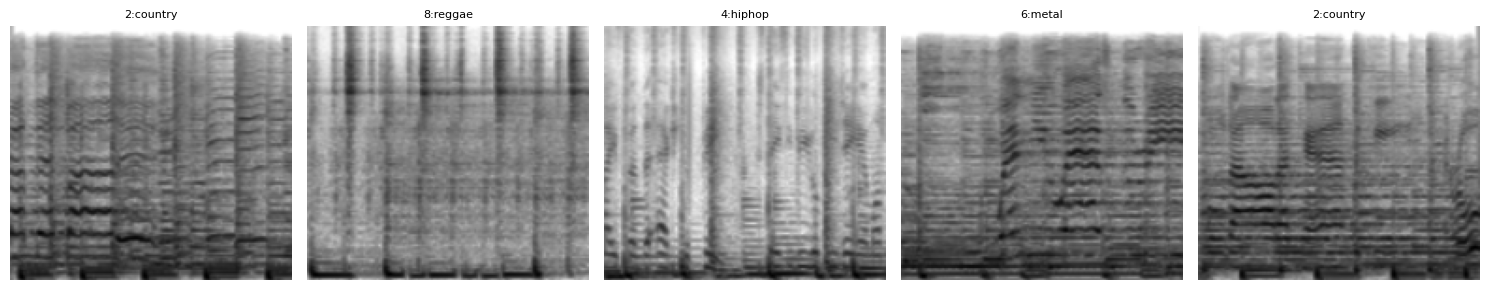

In [10]:
GENRES = sorted(p.name for p in DATA_ROOT.iterdir() if p.is_dir())
X, y, file_ids = build_dataset(DATA_ROOT, GENRES, CONFIG,
                               normalise=True, return_filenames=True)

verify_labels(X, y, GENRES, n_show=5)
check_file_label_consistency(file_ids, y, GENRES)

shape : (150, 150, 1)
dtype : float32
Value range : -2.7107673 → 2.8434355


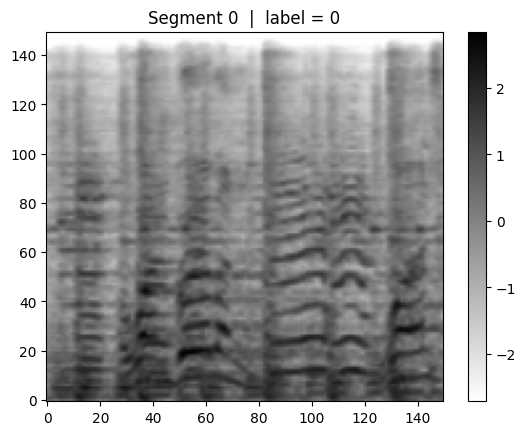

In [ ]:
print("shape :", X[0].shape)
print("dtype :", X[0].dtype)
print("Value range :", X[0].min(), "→", X[0].max())

import matplotlib.pyplot as plt
plt.imshow(X[0].squeeze(), origin="lower", aspect="auto", cmap="gray_r")
plt.title(f"Segment 0  |  label = {y[0]}")
plt.colorbar(); plt.show()


### Segment-Level Label Validation

This cell constructs a `DataFrame` (`segments_df`) containing each audio segment's original filename, assigned label, and corresponding genre. Two key operations are performed:

- **Pivot Table Creation**:  
  A pivot table is generated to show how many segments per audio file were labeled under each genre. This helps identify any discrepancies in labeling consistency.

- **Conflict Detection**:  
  A check is performed to identify audio files (`file`) associated with multiple genres. A file with more than one unique genre label across its segments is flagged as a conflict. If no such cases are found, a confirmation message is printed.

These checks ensure that each source `.wav` file contributes segments exclusively labeled under a single genre, maintaining the semantic consistency of training samples.


In [14]:
segments_df = pd.DataFrame({
    "file" : file_ids,
    "label": y,
    "genre": [GENRES[i] for i in y]
})

pivot = (segments_df.groupby(["file","genre"])
         .size().unstack(fill_value=0).reset_index())

conflict_df = (segments_df.groupby("file")["genre"]
               .nunique().reset_index(name="u").query("u>1"))

print("segments_df:", segments_df.shape)
print("pivot table :", pivot.shape)
if conflict_df.empty:
    print("No mixed‑label files")
else:
    print("Mixed‑label files detected "); display(conflict_df)


segments_df: (18972, 3)
pivot table : (999, 11)
No mixed‑label files


### Saving Processed Dataset as NumPy Arrays

This cell saves the generated mel spectrogram dataset to disk using NumPy’s binary `.npy` format for efficient storage and loading:

1. **Directory Creation**:  
   A new directory `spectrograms/` is created under the project’s data folder to store the processed arrays.

2. **Filename Assignment**:  
   Concrete file paths are defined for storing input spectrograms (`X_mels.npy`) and corresponding labels (`y_labels.npy`).

3. **Saving Arrays**:  
   The arrays `X` (mel spectrograms) and `y` (labels) are saved using `np.save()` with pickling disabled for safety and speed.

4. **Data Integrity Check**:  
   A round-trip assertion verifies that the saved files can be loaded back and match the original arrays exactly, ensuring data integrity.

These saved arrays can be efficiently loaded during model training, bypassing the need to regenerate spectrograms during each run.


In [ ]:
SPEC_ROOT = PROJECT_ROOT / "data" / "spectrograms"
SPEC_ROOT.mkdir(parents=True, exist_ok=True)

x_path = SPEC_ROOT / "X_mels.npy"
y_path = SPEC_ROOT / "y_labels.npy"

np.save(x_path, X, allow_pickle=False)
np.save(y_path, y, allow_pickle=False)

assert np.array_equal(np.load(x_path), X)
assert np.array_equal(np.load(y_path), y)

print(f"Saved arrays to\n   • {x_path}\n   • {y_path}")

Saved arrays to
   • /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/data/spectrograms/X_mels.npy
   • /Users/jiveshdhakate/Documents/UCD Sem 2/Deep Learning/Project/music_genre_classifier/data/spectrograms/y_labels.npy


### Verifying Saved Spectrogram Data

This cell reloads the previously saved mel spectrograms and labels from disk to confirm their integrity and inspect a sample:

- **Memory-Efficient Loading**:  
  The spectrogram data is loaded using NumPy's `mmap_mode="r"` to enable read-only memory mapping, which is useful for handling large arrays without loading them entirely into RAM.

- **Sample Inspection**:  
  A single spectrogram (index 0) is selected, and its shape, label, and pixel value range are printed for verification. This confirms that the data has been saved and retrieved correctly.

- **Visual Sanity Check**:  
  A grayscale visualization of the selected spectrogram is displayed to verify the quality and structure of the input. This helps ensure the mel features remain intact after disk I/O operations.

This verification confirms the correctness of the data saving pipeline and readiness for model training or feature analysis.


Sample index : 0
Numeric label: 0
Array shape  : (150, 150)
Value range  : -2.7107673 → 2.8434355


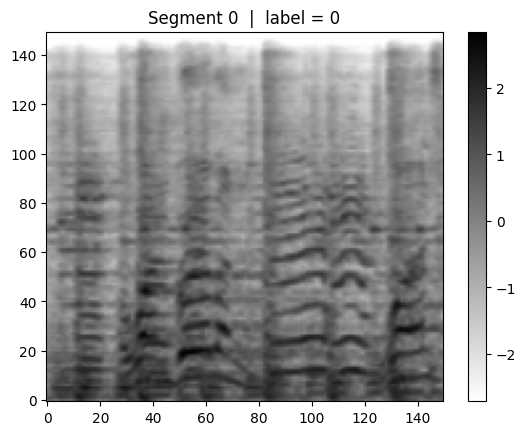

In [ ]:
SPEC_ROOT = PROJECT_ROOT / "data" / "spectrograms"
x_path    = SPEC_ROOT / "X_mels.npy"
y_path    = SPEC_ROOT / "y_labels.npy"

X = np.load(x_path, mmap_mode="r")   
y = np.load(y_path)                  

idx = 0                               
spec = X[idx].squeeze()              
label_num = y[idx]

print("Sample index :", idx)
print("Numeric label:", label_num)
print("Array shape  :", spec.shape)
print("Value range  :", spec.min(), "→", spec.max())

import matplotlib.pyplot as plt
plt.imshow(X[idx].squeeze(), origin="lower", aspect="auto", cmap="gray_r")
plt.title(f"Segment 0  |  label = {y[idx]}")
plt.colorbar(); plt.show()

